In [37]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import  SimpleImputer
from sklearn.preprocessing import StandardScaler , LabelEncoder
from sklearn.model_selection import cross_val_score , train_test_split , GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns




In [56]:
def engineer_features(data):
  data = data.copy()
  data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
  data['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',
                                   'Don', 'Dr', 'Major', 'Rev', 'Sir', 
                                   'Jonkheer', 'Dona'], 'Rare' , inplace=True)
  data['Title'] = data['Title'].replace('Mlle', 'Miss')
  data['Title'] = data['Title'].replace('Ms', 'Miss')
  data['Title'] = data['Title'].replace('Mme', 'Mrs')
  title_mapping = {'Mr' : 1 , 'Miss' : 2 , 'Mrs' : 3, 'Master' : 4, 'Rare' : 5}
  data["Title"] = data["Title"].map(title_mapping)
  
  # combining SibSp Parch in familysize
  data['FamilySize'] = data['SibSp'] + data['Parch'] + 1 
  
  #isAlone feature
  data["IsAlone"] = 1
  data.loc[data["FamilySize"] > 1 , 'IsAlone'] = 0
  
  #embarked filling missing values with mode 
  data["Embarked"] = data["Embarked"].fillna(data["Embarked"].mode()[0])
  
  #fare
  data["Fare"] = data["Fare"].fillna(data["Fare"].median())
  
  #estimate age missing values
  age_by_pclass_sex = data.groupby(["Pclass" , 'Sex'])['Age'].median()
  data["Age"] = data.apply(lambda row : age_by_pclass_sex[row["Pclass"] , row["Sex"]] if pd.isnull(row['Age']) else row['Age'] , axis=1)
  
  #partie numérique de Ticket
  data['TicketNumber'] = data["Ticket"].apply(lambda x: ''.join([char for char in x if char.isdigit()])
   if isinstance(x,str) else np.nan)
  data['TicketNumber'] = pd.to_numeric(data["TicketNumber"] , errors='coerce')
  
  data['TicketNumber'] = data['TicketNumber'].fillna(data['TicketNumber'].median())
  scaler = StandardScaler()
  data['TicketNumber'] = scaler.fit_transform(data[['TicketNumber']])
  
  #encoding categorical values
  data = pd.get_dummies(data, columns=['Sex', 'Embarked'], dummy_na=True)
  
  return data
  

<>:3: SyntaxWarning: invalid escape sequence '\.'
<>:3: SyntaxWarning: invalid escape sequence '\.'
C:\Users\dell\AppData\Local\Temp\ipykernel_9120\2848948073.py:3: SyntaxWarning: invalid escape sequence '\.'
  data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


In [57]:
traindata = pd.read_csv('data/train.csv')
testdata = pd.read_csv("data/test.csv")
train_data = engineer_features(traindata)
test_data = engineer_features(testdata)


C:\Users\dell\AppData\Local\Temp\ipykernel_9120\2848948073.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',
C:\Users\dell\AppData\Local\Temp\ipykernel_9120\2848948073.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

In [58]:
train_data['Title']

0      1
1      3
2      2
3      3
4      1
      ..
886    5
887    2
888    2
889    1
890    1
Name: Title, Length: 891, dtype: int64

In [28]:
# def visualize_features(data):
  #already in https://www.kaggle.com/code/tomitatsu5/tomitaka-ai-skillmap-lv3-submission/notebook

In [64]:
features = train_data.columns.tolist()
features.remove('Survived')
features.remove('Name')
features.remove('Ticket')
features.remove('Cabin')
features.remove('SibSp')
features.remove('Parch')
features.remove('Sex_female')
features.remove('PassengerId')

X = train_data[features]
y = train_data['Survived']
X_test = test_data[features]
specifc_rows = X[X['Title'] == 5]
specifc_rows

,Pclass,Age,Fare,Title,FamilySize,IsAlone,TicketNumber,Sex_male,Sex_nan,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
30,1,40.0,27.7208,5,1,1,-0.215492,True,False,True,False,False,False
149,2,42.0,13.0000,5,1,1,-0.149257,True,False,False,False,True,False
150,2,51.0,12.5250,5,1,1,-0.220294,True,False,False,False,True,False
245,1,44.0,90.0000,5,3,0,-0.214812,True,False,False,True,False,False
249,2,54.0,26.0000,5,2,0,-0.149274,True,False,False,False,True,False
317,2,54.0,14.0000,5,1,1,-0.212158,True,False,False,False,True,False
398,2,23.0,10.5000,5,1,1,-0.149267,True,False,False,False,True,False
449,1,52.0,30.5000,5,1,1,-0.187391,True,False,False,False,True,False
536,1,45.0,26.5500,5,1,1,-0.187606,True,False,False,False,True,False
556,1,48.0,39.6000,5,2,0,-0.217200,False,False,True,False,False,False


In [65]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X) , columns=X.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test) , columns=X_test.columns)
X


,Pclass,Age,Fare,Title,FamilySize,IsAlone,TicketNumber,Sex_male,Sex_nan,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,0.827377,-0.534891,-0.502445,-0.707550,0.059160,-1.231645,-0.068371,0.737695,0.0,-0.482043,-0.307562,0.615838,0.0
1,-1.566107,0.668392,0.786845,1.235215,0.059160,-1.231645,-0.215492,-1.355574,0.0,2.074505,-0.307562,-1.623803,0.0
2,0.827377,-0.234070,-0.488854,0.263832,-0.560975,0.811922,6.528547,-1.355574,0.0,-0.482043,-0.307562,0.615838,0.0
3,-1.566107,0.442776,0.420730,1.235215,0.059160,-1.231645,-0.187386,-1.355574,0.0,-0.482043,-0.307562,0.615838,0.0
4,0.827377,0.442776,-0.486337,-0.707550,-0.560975,0.811922,-0.111528,0.737695,0.0,-0.482043,-0.307562,0.615838,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,-0.369365,-0.158865,-0.386671,3.177981,-0.560975,0.811922,-0.158833,0.737695,0.0,-0.482043,-0.307562,0.615838,0.0
887,-1.566107,-0.760507,-0.044381,0.263832,-0.560975,0.811922,-0.187897,-1.355574,0.0,-0.482043,-0.307562,0.615838,0.0
888,0.827377,-0.572494,-0.176263,0.263832,1.299429,-1.231645,-0.218704,-1.355574,0.0,-0.482043,-0.307562,0.615838,0.0
889,-1.566107,-0.234070,-0.044381,-0.707550,-0.560975,0.811922,-0.188097,0.737695,0.0,2.074505,-0.307562,-1.623803,0.0


In [66]:
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=200, max_depth=5, min_samples_leaf=3, min_samples_split=12, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=7, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "xgb" : XGBClassifier(n_estimators=100 , learning_rate=0.1)
}
#Dictionnaire pour stocker l'importance des features
importances = {modelName: [] for modelName in models.keys()} # chaque model a une liste
importances



{'RandomForest': [],
 'ExtraTrees': [],
 'GradientBoosting': [],
 'AdaBoost': [],
 'xgb': []}

In [68]:
for modelname , model in models.items():
  model.fit(X, y)
  if hasattr(model , 'feature_importances_'): # has attribute
    importances[modelname] = model.feature_importances_
    


mean_importances = np.mean([importances[name] for name in importances if len(importances[name]) > 0], axis=0) # ex : mean of importance of title feature in all models
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': mean_importances})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)
feature_importance

c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


,feature,importance
3,Title,0.284613
6,TicketNumber,0.158793
7,Sex_male,0.144129
2,Fare,0.122060
0,Pclass,0.101188
1,Age,0.075171
4,FamilySize,0.066518
11,Embarked_S,0.016101
5,IsAlone,0.013279
9,Embarked_C,0.010718


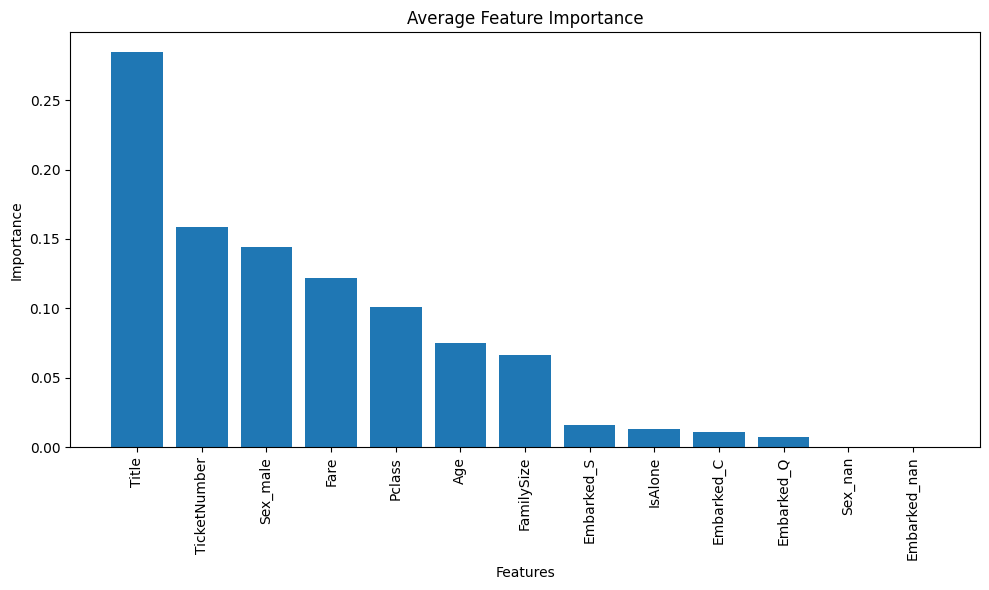

In [70]:
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Average Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [71]:
threshold = 0.09
important_features = feature_importance[feature_importance["importance"] >= threshold]['feature'].tolist()
important_features

['Title', 'TicketNumber', 'Sex_male', 'Fare', 'Pclass']

In [72]:
X_selected = X[important_features]
X_test_selected = X_test[important_features]

In [73]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [74]:
model_scores = {}
for name, model in models.items():
    print(f"Evaluating {name}...")
    model.fit(X_train, y_train)
    holdout_score = model.score(X_holdout, y_holdout)
    model_scores[name] = holdout_score
    print(f"{name} Holdout Accuracy: {holdout_score:.4f}")
    
    
best_model_name = max(model_scores, key=model_scores.get)
best_model = models[best_model_name]


print(f"\nBest model: {best_model_name} with Holdout Accuracy: {model_scores[best_model_name]:.4f}")

Evaluating RandomForest...
RandomForest Holdout Accuracy: 0.8212
Evaluating ExtraTrees...
ExtraTrees Holdout Accuracy: 0.7989
Evaluating GradientBoosting...
GradientBoosting Holdout Accuracy: 0.8603
Evaluating AdaBoost...


c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Holdout Accuracy: 0.8156
Evaluating xgb...
xgb Holdout Accuracy: 0.8603

Best model: GradientBoosting with Holdout Accuracy: 0.8603


In [75]:
#train it with all train data (with important features)
best_model.fit(X_selected , y)

#predict
predections = best_model.predict(X_test_selected) # X_test_selected is X_test but with important features 

In [80]:
submissionfile = pd.DataFrame({'PassengerId': test_data['PassengerId'] , 'Survived' : predections})
submissionfile.to_csv(f'submission.csv' , index=False)
print("submission done")

submission done
